In [1]:
# Source: node04
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

In [2]:
import sys
sys.executable

'/Users/josh/opt/anaconda3/bin/python'

In [3]:
import sys
import os
import copy
import pathlib
import time
import gc

from tqdm import tqdm, trange
# from tqdm import trange

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy

import torch
import torchvision
import torchvision.transforms as transforms

# import cuml

# for creating validation set
import sklearn
from sklearn.model_selection import train_test_split

%matplotlib inline
%matplotlib inline
# %matplotlib inline
# %matplotlib qt

In [4]:
# base_dir = '/n/data1/hms/neurobio/sabatini/josh'
base_dir = '/Users/josh/Documents/'
DEVICE = 'cpu'


In [142]:

import sys

sys.path.append(f'{base_dir}/github_repos')
# sys.path.append(f'/media/rich/Home_Linux_partition/github_repos')
dir_folders = f'{base_dir}/label_data'


%load_ext autoreload
%autoreload 2
from basic_neural_processing_modules import math_functions, classification, h5_handling, plotting_helpers, indexing, misc, decomposition, torch_helpers
from GCaMP_ROI_classifier.new_stuff import util, models, training_simCLR, augmentation, training_classHead, training_supervised



The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Import unlabeled training data

In [8]:
# data_unlabeled = h5_handling.simple_load(path=r'/media/rich/bigSSD/for_Josh/GCAMP_ROI_Classifier_data/masks_20211202_balanced.h5')
data_unlabeled = h5_handling.simple_load(path=f'{base_dir}/label_data/masks_20211202_balanced.h5')

masks_cat_raw = torch.as_tensor(np.concatenate((data_unlabeled['SYTmasks'], data_unlabeled['NPmasks'], data_unlabeled['RHmasks']), axis=0), dtype=torch.float32, device='cpu')

In [47]:
data_labeled = h5_handling.simple_load(path=f'{base_dir}/label_data/masks_20211202_unbalanced.h5')

In [48]:
masks_SYT = data_labeled['SYTmasks']
labels_SYT = classification.squeeze_integers(data_labeled['SYTlabels'])

In [49]:
nan_lst = np.concatenate(np.where(np.isnan(masks_SYT).sum(axis=-1).sum(axis=-1)))
non_nan = [_ for _ in range(masks_SYT.shape[0]) if _ not in nan_lst]
labels_SYT = labels_SYT[non_nan]
masks_SYT = masks_SYT[non_nan]

In [50]:
X_labeled_train_SYT, X_labeled_val_SYT, y_labeled_train_SYT, y_labeled_val_SYT = train_test_split(masks_SYT, labels_SYT, test_size = 0.2)

toss any NaNs

In [13]:
print(f'Number of masks: {masks_cat_raw.shape}')

ROIs_without_NaNs = torch.where(~torch.any(torch.any(torch.isnan(masks_cat_raw), dim=1), dim=1))[0]
masks_cat = masks_cat_raw[ROIs_without_NaNs]

print(f'Number of masks: {masks_cat.shape}')

Number of masks: torch.Size([711808, 36, 36])
Number of masks: torch.Size([711807, 36, 36])


## Import labeled training data

concatenated images shape: (9715, 32, 32)


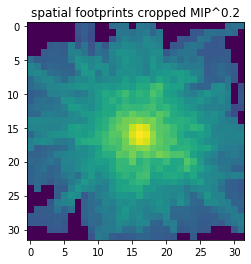

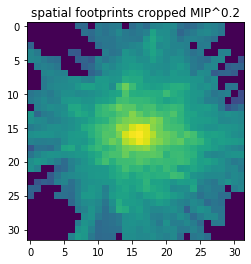

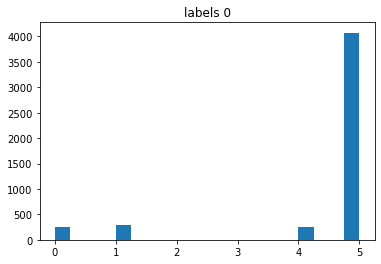

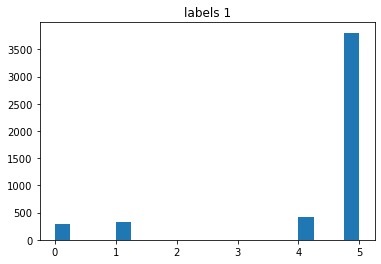

In [14]:
dir_folders = f'{base_dir}/label_data'
# dir_folders = r'/media/rich/bigSSD/for_Josh/GCAMP_ROI_Classifier_data/label_data'
# dir_folders = r'/users/Josh/Documents/Harvard/label_data'
folders = [r'mouse 6_28 _ day 20200903/',
             r'mouse6_28 _ day20200815/']
fileNames_statFiles = [r'stat.npy']*len(folders)
paths_statFiles = [pathlib.Path(dir_folders) / folders[ii] / fileNames_statFiles[ii] for ii in range(len(folders))]

sf_all = util.import_multiple_stat_files(   paths_statFiles=paths_statFiles,
                                            fileNames_statFiles=fileNames_statFiles,
                                            out_height_width=[32,32],
                                            max_footprint_width=241,
                                            plot_pref=True)
images_labeled_raw = np.concatenate(sf_all, axis=0)
images_labeled_raw = (images_labeled_raw / np.max(images_labeled_raw, axis=(1,2), keepdims=True)) * 1
print(f'concatenated images shape: {images_labeled_raw.shape}')

fileNames_labelFiles = ['labels_posthoc_filledIn_allCells.npy',
             'labels_posthoc_all.npy']
paths_labelFiles = [pathlib.Path(dir_folders) / folders[ii] / fileNames_labelFiles[ii] for ii in range(len(folders))]

labels_all = util.import_multiple_label_files(paths_labelFiles=paths_labelFiles,
                                       plot_pref=True)
labels_raw = np.concatenate(labels_all)

assert np.alltrue([sf_all[ii].shape[0] == labels_all[ii].shape[0] for ii in range(len(sf_all))]) , 'num images in stat files does not correspond to num labels'

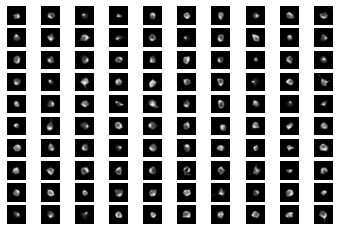

In [15]:
%matplotlib inline

plotting_helpers.plot_image_grid(images=images_labeled_raw,
                                labels=None,
                                grid_shape=(10,10), cmap=plt.get_cmap('gray'));

In [16]:
labels = classification.squeeze_integers(labels_raw)
images_labeled = images_labeled_raw[labels != 2]
labels = labels[labels != 2]
labels = classification.squeeze_integers(labels)

## Balance classes of inputs

In [17]:
duplicates = 1
balanced = True

images_dup = np.tile(images_labeled , (duplicates , 1 , 1))
labels_dup = np.tile(labels , (duplicates))

print(images_dup.shape)
print(labels_dup.shape)

if balanced:
    numToGetTo = np.sum(labels_dup==0)
    print(numToGetTo)
    for ii in np.array([1,2,3]):
  #     idxToDelete = np.cumsum(labels_dup==ii) <= (np.sum(labels_dup==ii) - numToGetTo)
        if ii==3:
            numToGetTo = np.sum(labels_dup==0)/1
        else:
            numToGetTo = np.sum(labels_dup==0)

        idxToDelete = (np.cumsum(labels_dup==ii) * (labels_dup==ii)) > numToGetTo
        images_dup = images_dup[idxToDelete==0,:,:]
        labels_dup = labels_dup[idxToDelete==0]





print(images_dup.shape)
print(labels_dup.shape)

numToGetTo = np.sum(labels_dup==0)
print(numToGetTo)

print(np.sum(labels_dup==0))
print(np.sum(labels_dup==1))
print(np.sum(labels_dup==4))
print(np.sum(labels_dup==5))
print(images_dup.shape)
print(labels_dup.shape)

(9714, 32, 32)
(9714,)
532
(2128, 32, 32)
(2128,)
532
532
532
0
0
(2128, 32, 32)
(2128,)


In [18]:
# create validation set

###### REMOVE WITH ENOUGH RAM
images = images_dup
labels = labels_dup

# X_labeled_train, X_labeled_val, y_labeled_train, y_labeled_val = train_test_split(images_dup, labels_dup, test_size = 0.3)
X_labeled_train, X_labeled_val, y_labeled_train, y_labeled_val = train_test_split(images_dup, labels_dup, test_size = 0.2)
# X_train, y_train = X_labeled_train, y_labeled_train

# X_labeled_val, X_test, y_labeled_val, y_test = train_test_split(X_labeled_val, y_labeled_val, test_size = 0.5)
X_val, X_test, y_val, y_test = train_test_split(X_labeled_val, y_labeled_val, test_size = 0.5)

(X_labeled_train.shape, y_labeled_train.shape), (X_labeled_val.shape, y_labeled_val.shape)

(((1702, 32, 32), (1702,)), ((426, 32, 32), (426,)))

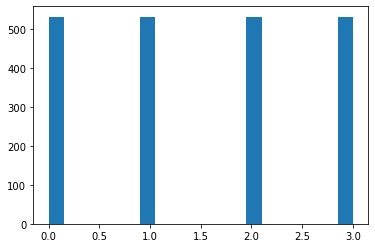

In [19]:
plt.figure()
plt.hist(labels_dup, 20);

In [20]:
images.shape

(2128, 32, 32)

# Train

In [21]:
# DEVICE = torch_helpers.set_device(use_GPU=True)
# DEVICE = torch_helpers.set_device(use_GPU=False)

### Define New model = model + pre-head + latent layer OR classification layer

In [22]:
class ModelTackOn(torch.nn.Module):
    def __init__(self, base_model, un_modified_model, pre_head_fc_sizes=[100], post_head_fc_sizes=[100], classifier_fc_sizes=None):
            super(ModelTackOn, self).__init__()
            self.base_model = base_model
            final_base_layer = list(un_modified_model.children())[-1]
            
            
            
            
            # TODO: Check to make sure this makes the process automatic!!!!
            while len(list(final_base_layer.children())) > 0:
                final_base_layer = list(final_base_layer.children())[0]
            
            
            
            
            
            
            # final_base_layer = list(list(model.children())[-1].children())[-1]
            # print(final_base_layer)

            self.pre_head_fc_lst = []
            self.post_head_fc_lst = []
            self.classifier_fc_lst = []

            self.init_prehead(final_base_layer, pre_head_fc_sizes)
            self.init_posthead(pre_head_fc_sizes[-1], post_head_fc_sizes)
            if classifier_fc_sizes is not None:
                self.init_classifier(pre_head_fc_sizes[-1], classifier_fc_sizes)
    
    def init_prehead(self, prv_layer, pre_head_fc_sizes):
        for i, pre_head_fc in enumerate(pre_head_fc_sizes):
            if i == 0:
                in_features = prv_layer.in_features if hasattr(prv_layer,'in_features') else 512
            else:
                in_features = pre_head_fc_sizes[i - 1]
            fc_layer = torch.nn.Linear(in_features=in_features, out_features=pre_head_fc)
            self.add_module(f'PreHead_{i}', fc_layer)
            self.pre_head_fc_lst.append(fc_layer)

#             if i < len(pre_head_fc_sizes) - 1:
            non_linearity = torch.nn.ReLU()
            self.add_module(f'PreHead_{i}_NonLinearity', non_linearity)
            self.pre_head_fc_lst.append(non_linearity)

    def init_posthead(self, prv_size, post_head_fc_sizes):
        for i, post_head_fc in enumerate(post_head_fc_sizes):
            if i == 0:
                in_features = prv_size
            else:
                in_features = post_head_fc_sizes[i - 1]
            fc_layer = torch.nn.Linear(in_features=in_features, out_features=post_head_fc)
            self.add_module(f'PostHead_{i}', fc_layer)
            self.post_head_fc_lst.append(fc_layer)

            if i < len(post_head_fc_sizes) - 1:
                non_linearity = torch.nn.ReLU()
                self.add_module(f'PostHead_{i}_NonLinearity', non_linearity)
                self.pre_head_fc_lst.append(non_linearity)
    
    def init_classifier(self, prv_size, classifier_fc_sizes):
            for i, classifier_fc in enumerate(classifier_fc_sizes):
                if i == 0:
                    in_features = prv_size
                else:
                    in_features = classifier_fc_sizes[i - 1]
            fc_layer = torch.nn.Linear(in_features=in_features, out_features=classifier_fc)
            self.add_module(f'Classifier_{i}', fc_layer)
            self.classifier_fc_lst.append(fc_layer)

    def reinit_classifier(self):
        for i_layer, layer in enumerate(self.classifier_fc_lst):
            layer.reset_parameters()
    
#     def forward(self, X):
#         interim = self.base_model(X)
#         interim = self.get_head(interim)
#         interim = self.get_latent(interim)
#         return interim

    def forward_classifier(self, X):
        interim = self.base_model(X)
        interim = self.get_head(interim)
        interim = self.classify(interim)
        return interim

    def forward_latent(self, X):
        interim = self.base_model(X)
        interim = self.get_head(interim)
        interim = self.get_latent(interim)
        return interim


    def get_head(self, base_out):
        # print('base_out', base_out.shape)
        head = base_out
        for pre_head_layer in self.pre_head_fc_lst:
          # print('pre_head_layer', pre_head_layer.in_features)
          head = pre_head_layer(head)
          # print('head', head.shape)
        return head

    def get_latent(self, head):
        latent = head
        for post_head_layer in self.post_head_fc_lst:
            latent = post_head_layer(latent)
        return latent

    def classify(self, head):
        logit = head
        for classifier_layer in self.classifier_fc_lst:
            logit = classifier_layer(logit)
        return logit

    def set_pre_head_grad(self, requires_grad=True):
        for layer in self.pre_head_fc_lst:
            for param in layer.parameters():
                param.requires_grad = requires_grad
                
    def set_post_head_grad(self, requires_grad=True):
        for layer in self.post_head_fc_lst:
            for param in layer.parameters():
                param.requires_grad = requires_grad

    def set_classifier_grad(self, requires_grad=True):
        for layer in self.classifier_fc_lst:
            for param in layer.parameters():
                param.requires_grad = requires_grad

    def prep_contrast(self):
        self.set_pre_head_grad(requires_grad=True)
        self.set_post_head_grad(requires_grad=True)
        self.set_classifier_grad(requires_grad=False)

    def prep_classifier(self):
        self.set_pre_head_grad(requires_grad=False)
        self.set_post_head_grad(requires_grad=False)
        self.set_classifier_grad(requires_grad=True)


In [23]:
# import torchvision.models

# # base_model = torchvision.models.resnet101(pretrained=True)
# base_model = torchvision.models.resnet18(pretrained=True)

# for param in base_model.parameters():
#     param.requires_grad = False

# retrain = list(base_model.children())[-1:]
# for layer in retrain:
#     params = layer.parameters()
#     for param in params:
#         param.requires_grad = True

In [24]:
import torchvision.models

base_model_unfrozen = torchvision.models.mobilenet_v3_small(pretrained=False)
for param in base_model_unfrozen.parameters():
    param.requires_grad = True

# base_model_frozen = torchvision.models.resnet101(pretrained=True)
# base_model_frozen = torchvision.models.resnet18(pretrained=True)
# base_model_frozen = torchvision.models.wide_resnet50_2(pretrained=True)
# base_model_frozen = torchvision.models.resnet50(pretrained=True)

In [25]:
# for param in base_model_frozen.parameters():
#     param.requires_grad = False

start with a pretrained resnet model, and chop off the final layer. This will be used as the base on which we add the pre-head layers (for expressivity), latent layers (for simCLR), or classification layers (for post-hoc logistic regression)

In [26]:
model_chopped = torch.nn.Sequential(*(list(base_model_unfrozen.children())[:-1] + [torch.nn.Flatten()]))

In [27]:
# base_model_unfrozen

### Make combined model
'model' has two forward methods. One for generating latents (for simCLR) and one for classifying labels

In [28]:
model = ModelTackOn(model_chopped, base_model_unfrozen, pre_head_fc_sizes=[1024, 512], post_head_fc_sizes=[64], classifier_fc_sizes=[len(np.unique(y_labeled_train))])
# model = ModelTackOn(model_chopped.to(DEVICE), base_model_frozen, pre_head_fc_sizes=[len(np.unique(y_train))], post_head_fc_sizes=[])
# model = ModelTackOn(model_chopped.to(DEVICE), base_model_frozen, pre_head_fc_sizes=[len(np.unique(y_train))], post_head_fc_sizes=[])

# model = torch.nn.Sequential([model_chopped.to(DEVICE), torch.nn.Linear], pre_head_fc_sizes=[len(np.unique(y_train))], post_head_fc_sizes=[])


# model = ModelTackOn(base_model_frozen, pre_head_fc_sizes=[len(np.unique(y_train))], post_head_fc_sizes=[])
# model = ModelTackOn(base_model, pre_head_fc_sizes=[len(np.unique(y_train))], post_head_fc_sizes=[])
model.train();

In [29]:
# # unfreeze particular blocks in ResNet model

# for name, param in list(model.named_parameters()):
#     if name[:10] == 'base_model':
#         if int(name[11]) < 6:
#             param.requires_grad = False
#         elif int(name[11]) >= 6:
#             param.requires_grad = True

for name, param in list(model.named_parameters()):
    if param.requires_grad:
        pass
    print(name, param.requires_grad)

base_model.0.0.0.weight True
base_model.0.0.1.weight True
base_model.0.0.1.bias True
base_model.0.1.block.0.0.weight True
base_model.0.1.block.0.1.weight True
base_model.0.1.block.0.1.bias True
base_model.0.1.block.1.fc1.weight True
base_model.0.1.block.1.fc1.bias True
base_model.0.1.block.1.fc2.weight True
base_model.0.1.block.1.fc2.bias True
base_model.0.1.block.2.0.weight True
base_model.0.1.block.2.1.weight True
base_model.0.1.block.2.1.bias True
base_model.0.2.block.0.0.weight True
base_model.0.2.block.0.1.weight True
base_model.0.2.block.0.1.bias True
base_model.0.2.block.1.0.weight True
base_model.0.2.block.1.1.weight True
base_model.0.2.block.1.1.bias True
base_model.0.2.block.2.0.weight True
base_model.0.2.block.2.1.weight True
base_model.0.2.block.2.1.bias True
base_model.0.3.block.0.0.weight True
base_model.0.3.block.0.1.weight True
base_model.0.3.block.0.1.bias True
base_model.0.3.block.1.0.weight True
base_model.0.3.block.1.1.weight True
base_model.0.3.block.1.1.bias True


## Define augmentation pipeline

In [30]:
import torchvision.transforms    

transforms = torch.nn.Sequential(
    torchvision.transforms.RandomHorizontalFlip(p=0.5),
        
    torchvision.transforms.RandomAffine(
                                        degrees=(-180,180),
                                        translate=(0.15, 0.15), #0, .3, .45 (DEFAULT)
                                        scale=(0.6, 1.2), # no scale (1,1), (0.4, 1.5)
                                        shear=(-15, 15, -15, 15),
                                        interpolation=torchvision.transforms.InterpolationMode.BILINEAR, 
                                        fill=0, 
                                        fillcolor=None, 
                                        resample=None),
    augmentation.AddPoissonNoise(   scaler_bounds=(10**(4.5), 10**(6.)),
                                    prob=1,
                                    base=1000,
                                    scaling='log'),
    augmentation.AddGaussianNoise(  mean=0, 
                                    std=0.00015,
                                    prob=1),
    
    augmentation.ScaleDynamicRange(scaler_bounds=(0,1)), # just clamping, both this and clamping = normalizing (DEFAULT)
    
    torchvision.transforms.Resize(size=(224,224), 
                                  interpolation=torchvision.transforms.InterpolationMode.BILINEAR), # To do or not to do (DEFAULT)
    
    augmentation.TileChannels(dim=0, n_channels=3),
)
    
scripted_transforms = torch.jit.script(transforms)

In [84]:
dataset_train = util.dataset_simCLR(
                                    torch.as_tensor(masks_cat, device='cpu', dtype=torch.float32), 
                                    torch.as_tensor(torch.zeros(masks_cat.shape[0]), device='cpu', dtype=torch.float32),

                                    n_transforms=2,
                                    class_weights=np.array([1]),
                                    # class_weights=np.array([1]*4)[np.random.randint(0,4, X_train.shape[0])],
                                    transform=scripted_transforms,
                                    # DEVICE='cpu',
                                    DEVICE='cpu',
                                    dtype_X=torch.float32,
                                    dtype_y=torch.int64,
                                    
                                    temp_uncertainty=16
                                    )
dataloader_train = torch.utils.data.DataLoader( dataset_train,
#                                                 batch_size=int(pct_batch_size*X_train.shape[0]),
                                                batch_size=900,
                                                shuffle=True,
                                                drop_last=True,
#                                                 pin_memory=True,
#                                                 num_workers=16,
#                                                 persistent_workers=True,
#                                                 # prefetch_factor=0
                                                )

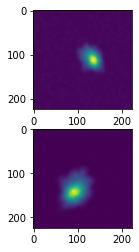

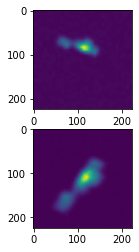

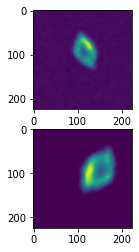

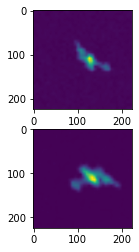

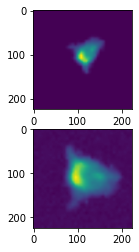

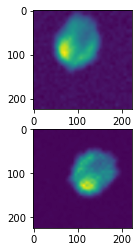

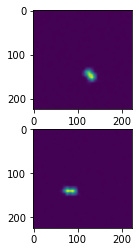

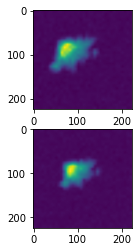

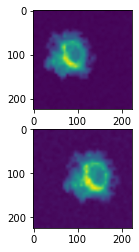

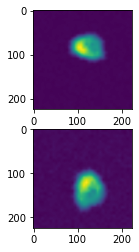

In [32]:
idx_rand = np.random.randint(0,masks_cat.shape[0], 10)
for ii in idx_rand:
    fig, axs = plt.subplots(2)
    axs[0].imshow(dataset_train[ii][0][0][0])
    axs[1].imshow(dataset_train[ii][0][1][0])

In [33]:
# torch_helpers.delete_all_cuda_tensors(globals())

import gc

torch.cuda.empty_cache()
gc.collect()
torch.cuda.empty_cache()
gc.collect()
torch.cuda.empty_cache()
gc.collect()
torch.cuda.empty_cache()
gc.collect()

0

## Training

In [34]:
model.to(DEVICE)
model.prep_contrast()

In [35]:
from torch.nn import CrossEntropyLoss
from torch.optim import Adam

import numpy as np

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC


# model = models.LeNet1(dropout_prob=0.3, momentum_val=0, n_output_features=64)


criterion = [CrossEntropyLoss()]
# criterion = CrossEntropyLoss(reduction='none')

# optimizer = Adam(model.parameters(), lr=1e-2, weight_decay=0.0)
# optimizer = Adam(model.parameters(), lr=2e-2)
optimizer = Adam(model.parameters(), lr=10**(-3.5), weight_decay=0.00001)

scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer,
                                                   gamma=1-0.0000,
#                                                    gamma=1,
                                                  )

criterion = [_.to(DEVICE) for _ in criterion]
losses_train, losses_val, val_accs, acc = [], [np.nan], [], []

In [36]:
model_file_name = 'ResNet18_simCLR_model_202112078_EOD_transfmod=mobilenet'
model.forward = model.forward_latent

In [34]:
l2_alpha = 0.000

n_epochs=300000
for epoch in tqdm(range(n_epochs)):
    print(f'epoch: {epoch}')
    loss_rolling_train = training_simCLR.epoch_step(dataloader_train, 
                                    model, 
                                    optimizer, 
                                    criterion,
                                    scheduler=scheduler,
                                    temperature=0.5,
                                    # l2_alpha,
                                    mode='semi-supervised',
                                    loss_rolling_train=losses_train, 
                                    loss_rolling_val=losses_val,
                                    device=DEVICE, 
                                    verbose=2,
                                    verbose_update_period=1,
                                   
#                                     do_validation=False,
#                                     X_val=x_feed_through_val,
#                                     y_val=torch.as_tensor(y_val, device=DEVICE)
                                   )
    
    
    torch.save(model.state_dict(), f'{base_dir}/github_repos/GCaMP_ROI_classifier/new_stuff/models/{model_file_name}.pth')

    losses_train_npy = np.array(losses_train)
    losses_val_npy = np.array(losses_val)
    val_accs_npy = np.array(val_accs)
    acc_npy = np.array(acc)

    np.save(f'{base_dir}/github_repos/GCaMP_ROI_classifier/new_stuff/model_performance/{model_file_name}_losses_train.npy', losses_train_npy)
    np.save(f'{base_dir}/github_repos/GCaMP_ROI_classifier/new_stuff/model_performance/{model_file_name}_losses_val.npy', losses_val_npy)
    np.save(f'{base_dir}/github_repos/GCaMP_ROI_classifier/new_stuff/model_performance/{model_file_name}_val_accs.npy', val_accs_npy)
    np.save(f'{base_dir}/github_repos/GCaMP_ROI_classifier/new_stuff/model_performance/{model_file_name}_tr_accs.npy', acc_npy)

In [37]:
losses_train_npy = np.load(f'{base_dir}/github_repos/GCaMP_ROI_classifier/new_stuff/model_performance/{model_file_name}_losses_train.npy')
losses_val_npy = np.load(f'{base_dir}/github_repos/GCaMP_ROI_classifier/new_stuff/model_performance/{model_file_name}_losses_val.npy')
val_accs_npy = np.load(f'{base_dir}/github_repos/GCaMP_ROI_classifier/new_stuff/model_performance/{model_file_name}_val_accs.npy')
acc_npy = np.load(f'{base_dir}/github_repos/GCaMP_ROI_classifier/new_stuff/model_performance/{model_file_name}_tr_accs.npy')

losses_train = losses_train_npy
losses_val = losses_val_npy
val_accs = val_accs_npy
acc = acc_npy

Text(0, 0.5, 'Loss')

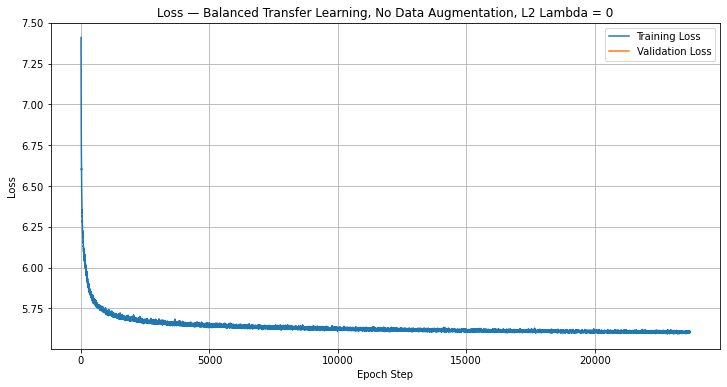

In [38]:
# import seaborn as sns
# sns.set(style='white', palette='bright', context='poster')
plt.rcdefaults()

%matplotlib inline
plt.figure(figsize=(12,6))
plt.plot(losses_train, label='Training Loss')
plt.plot(losses_val, label='Validation Loss')
plt.title(f'Loss — Balanced Transfer Learning, No Data Augmentation, L2 Lambda = {0}')
plt.legend()
plt.grid()
plt.xlabel('Epoch Step')
plt.ylabel('Loss')
# plt.savefig('./Training-Loss.png')

In [39]:
break

SyntaxError: 'break' outside loop (<ipython-input-39-6aaf1f276005>, line 1)

In [ ]:
model_file_name = 'ResNet18_simCLR_model_202112078_temp=-1.0'

# torch.save(model.state_dict(), '/media/rich/Home_Linux_partition/github_repos/GCaMP_ROI_classifier/new_stuff/models/ResNet18_simCLR_model_20211205_3.pth')
torch.save(model.state_dict(), f'{base_dir}/github_repos/GCaMP_ROI_classifier/new_stuff/models/{model_file_name}.pth')

In [37]:
# model.load_state_dict(torch.load('/media/rich/Home_Linux_partition/github_repos/GCaMP_ROI_classifier/new_stuff/models/ResNet18_simCLR_model_20211205_2.pth'))
model.load_state_dict(torch.load(f'{base_dir}/github_repos/GCaMP_ROI_classifier/new_stuff/models/{model_file_name}.pth', map_location=torch.device('cpu')))

<All keys matched successfully>

In [ ]:
losses_train_npy = np.array(losses_train)
losses_val_npy = np.array(losses_val)
val_accs_npy = np.array(val_accs)
acc_npy = np.array(acc)

np.save(f'{base_dir}/github_repos/GCaMP_ROI_classifier/new_stuff/model_performance/{model_file_name}_losses_train.npy', losses_train_npy)
np.save(f'{base_dir}/github_repos/GCaMP_ROI_classifier/new_stuff/model_performance/{model_file_name}_losses_val.npy', losses_val_npy)
np.save(f'{base_dir}/github_repos/GCaMP_ROI_classifier/new_stuff/model_performance/{model_file_name}_val_accs.npy', val_accs_npy)
np.save(f'{base_dir}/github_repos/GCaMP_ROI_classifier/new_stuff/model_performance/{model_file_name}_tr_accs.npy', acc_npy)

## Train classifier using classifier layers of model (or do supervised learning)

Freeze pre-head layers, unfreeze classification layers

Define labeled dataset to use

Train model

In [ ]:
from torch.nn import CrossEntropyLoss
from torch.optim import Adam

import numpy as np

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

criterion = [CrossEntropyLoss()]
# criterion = CrossEntropyLoss(reduction='none')

# optimizer = Adam(model.parameters(), lr=1e-2, weight_decay=0.0)
# optimizer = Adam(model.parameters(), lr=2e-2)
optimizer = Adam(model.parameters(), lr=10**(-4.5))
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer,
                                                   gamma=1-0.0000,
#                                                    gamma=1,
                                                  )
criterion = [_.to(DEVICE) for _ in criterion]
losses_train, losses_val, val_accs, acc = [], [np.nan], [], []

In [ ]:
def transform_null(var):
    return(var)

In [ ]:
model.reinit_classifier()
model.train()
model.prep_classifier()

In [ ]:
dataset_validation = util.dataset_simCLR(
                                    torch.as_tensor(masks_cat, device='cpu', dtype=torch.float32), 
                                    torch.as_tensor(torch.zeros(masks_cat.shape[0]), device='cpu', dtype=torch.float32),

                                    n_transforms=1,
                                    class_weights=np.array([1]),
                                    # class_weights=np.array([1]*4)[np.random.randint(0,4, X_train.shape[0])],
                                    transform=scripted_transforms_validation,
                                    # DEVICE='cpu',
                                    DEVICE='cpu',
                                    dtype_X=torch.float32,
                                    dtype_y=torch.int64,
                                    
                                    temp_uncertainty=16
                                    )
dataloader_validation = torch.utils.data.DataLoader( dataset_validation,
#                                                 batch_size=int(pct_batch_size*X_train.shape[0]),
                                                batch_size=1024,
                                                shuffle=True,
                                                drop_last=True,
                                                pin_memory=True,
                                                num_workers=32,
                                                persistent_workers=True,
                                                # prefetch_factor=0
                                                )

In [ ]:
data_unlabeled = torch.as_tensor(masks_cat, dtype=torch.float32, device='cpu')

# model.to(DEVICE)

l2_alpha = 0.000

n_epochs=300000
for epoch in range(n_epochs):
    print(f'epoch: {epoch}')
    loss_rolling_train = training_simCLR.epoch_step(dataloader_validation, 
                                    model, 
                                    optimizer, 
                                    criterion, 

                                    # penalized_params, l2_alpha,

                                    scheduler=scheduler,
                                    L2_alpha=0.04,
                                    mode='supervised',
                                    loss_rolling_train=losses_train, 
                                    device=DEVICE, 
                                    loss_rolling_val=losses_val,
                                    verbose=2,
                                    verbose_update_period=1,
                                   
#                                     do_validation=False,
#                                     X_val=x_feed_through_val,
#                                     y_val=torch.as_tensor(y_val, device=DEVICE)
                                   )

Evalculate model

In [ ]:
%matplotlib notebook

plt.figure()
plt.plot(loss_rolling_train)

data_in = torch.as_tensor(X_labeled_val, dtype=torch.float32, device=DEVICE)
# data_in = torch.as_tensor(X_labeled_train, dtype=torch.float32, device=DEVICE)
data_in = util.tile_channels(data_in[:,None,...], dim=1)
proba = torch.nn.functional.softmax(model.forward_classifier(data_in), dim=1)
cm = classification.confusion_matrix(proba.detach().cpu().numpy(), y_labeled_val)
# cm = classification.confusion_matrix(proba.detach().cpu().numpy(), y_labeled_train)

plt.figure()
plt.imshow(cm, aspect='auto')
plt.colorbar()

In [ ]:
%matplotlib notebook
data_in = torch.as_tensor(X_labeled_train, dtype=torch.float32, device=DEVICE)
data_in = util.tile_channels(data_in[:,None,...], dim=1)
proba = torch.nn.functional.softmax(model.forward_classifier(data_in), dim=1)
cm = classification.confusion_matrix(proba.detach().cpu().numpy(), y_labeled_train)

plt.figure()
plt.imshow(cm)
plt.colorbar()

## Use sklearn to train classifier

In [51]:
transforms_validation = torch.nn.Sequential(
    augmentation.ScaleDynamicRange(scaler_bounds=(0,1)),
    torchvision.transforms.Resize(size=(224,224),
                                  interpolation=torchvision.transforms.InterpolationMode.BILINEAR), 
    augmentation.TileChannels(dim=0, n_channels=3),
#     augmentation.Normalize(  means=[0.485, 0.456, 0.406],
#                              stds=[0.229, 0.224, 0.225]),
#     torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406],
#                                      std=[0.229, 0.224, 0.225],
#                                      inplace=False),
)
scripted_transforms_validation = torch.jit.script(transforms_validation)
# scripted_transforms = transforms


In [121]:
dataset_labeled_train = util.dataset_simCLR(
#                                     torch.as_tensor(X_labeled_train, device='cpu', dtype=torch.float32), 
                                    torch.as_tensor(X_labeled_train_SYT, device='cpu', dtype=torch.float32), 
#                                     torch.as_tensor(torch.zeros(X_labeled_train.shape[0]), device='cpu', dtype=torch.float32),
                                    torch.as_tensor(torch.zeros(X_labeled_train_SYT.shape[0]), device='cpu', dtype=torch.float32),

                                    n_transforms=1,
                                    class_weights=np.array([1]),
                                    # class_weights=np.array([1]*4)[np.random.randint(0,4, X_train.shape[0])],
                                    transform=scripted_transforms_validation,
                                    # DEVICE='cpu',
                                    DEVICE='cpu',
                                    dtype_X=torch.float32,
                                    dtype_y=torch.int64,
                                    
                                    temp_uncertainty=16
                                    )
dataset_labeled_val = util.dataset_simCLR(
#                                     torch.as_tensor(X_labeled_val, device='cpu', dtype=torch.float32), 
                                    torch.as_tensor(X_labeled_val_SYT, device='cpu', dtype=torch.float32), 
#                                     torch.as_tensor(torch.zeros(X_labeled_val.shape[0]), device='cpu', dtype=torch.float32),
                                    torch.as_tensor(torch.zeros(X_labeled_val_SYT.shape[0]), device='cpu', dtype=torch.float32),

                                    n_transforms=1,
                                    class_weights=np.array([1]),
                                    # class_weights=np.array([1]*4)[np.random.randint(0,4, X_train.shape[0])],
                                    transform=scripted_transforms_validation,
                                    # DEVICE='cpu',
                                    DEVICE='cpu',
                                    dtype_X=torch.float32,
                                    dtype_y=torch.int64,
                                    
                                    temp_uncertainty=16
                                    )
dataloader_labeled_train = torch.utils.data.DataLoader( dataset_labeled_train,
    #                                                 batch_size=int(pct_batch_size*X_train.shape[0]),
                                                    batch_size=1024,
                                                    shuffle=False,
                                                    drop_last=False,
#                                                     pin_memory=True,
#                                                     num_workers=32,
#                                                     persistent_workers=True,
#                                                     # prefetch_factor=0
                                                    )
dataloader_labeled_val = torch.utils.data.DataLoader( dataset_labeled_val,
    #                                                 batch_size=int(pct_batch_size*X_train.shape[0]),
                                                    batch_size=1024,
                                                    shuffle=False,
                                                    drop_last=False,
#                                                     pin_memory=True,
#                                                     num_workers=32,
#                                                     persistent_workers=True,
#                                                     # prefetch_factor=0
                                                    )


In [113]:
# DEVICE = torch_helpers.set_device(use_GPU=True)

In [127]:
model.eval()
model.to(DEVICE)
features_train = torch.cat([model.get_head(model.base_model(data[0][0].to(DEVICE))).detach().cpu() for data in dataloader_labeled_train], dim=0)
features_val   = torch.cat([model.get_head(model.base_model(data[0][0].to(DEVICE))).detach().cpu() for data in dataloader_labeled_val], dim=0)

<IPython.core.display.Javascript object>


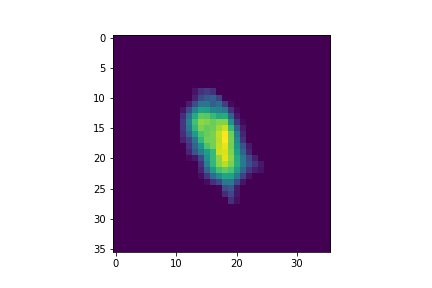

In [133]:
plt.figure()
plt.imshow(masks_cat_raw[1000])

<IPython.core.display.Javascript object>


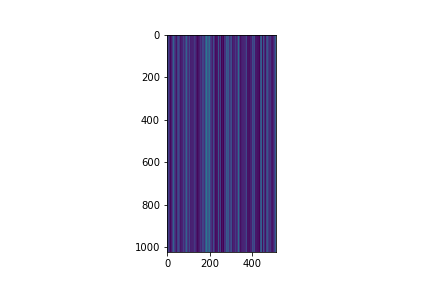

In [134]:
for ii, data in enumerate(dataloader_labeled_train):
# for ii, data in enumerate(dataloader_train):
    test = model.get_head(model.base_model(data[0][0].to(DEVICE))).detach().cpu()
#     test = model.base_model(data[0][0].to(DEVICE)).detach().cpu()

#     test = data[0][0][4000][0]
#     print(len(data))
    plt.figure()
    plt.imshow(test)
    if ii == 0:
        break

In [135]:
from sklearn.decomposition import PCA
pc = PCA()
pc.fit(test)

PCA()

<IPython.core.display.Javascript object>


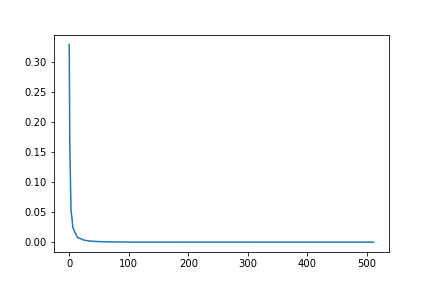

In [136]:
plt.figure()
plt.plot(pc.explained_variance_ratio_)

In [132]:
test = torch.cat([model.get_head(model.base_model(data[0][0].to(DEVICE))).detach().cpu() for data in dataloader_labeled_train], dim=0)


KeyboardInterrupt: 

run a sweep of logistic regressions over C (1/L2) parameter

In [198]:
_, features_embedded_tr, _, evr = decomposition.torch_pca(features_train, device=DEVICE, return_cpu=True)
_, features_embedded_val, _, evr = decomposition.torch_pca(features_val, device=DEVICE, return_cpu=True)

In [199]:
features_embedded_tr = features_embedded_tr * (10**8)
features_embedded_val = features_embedded_val * (10**8)

In [189]:
features_embedded_tr = features_embedded_tr[:, :5] * (10**8)
features_embedded_val = features_embedded_val[:, :5] * (10**8)

<IPython.core.display.Javascript object>


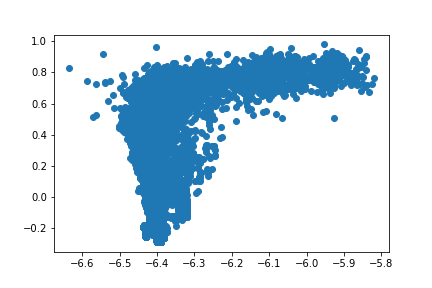

In [190]:
plt.figure()
plt.scatter(features_embedded_tr[:,0], features_embedded_tr[:,1])

<IPython.core.display.Javascript object>


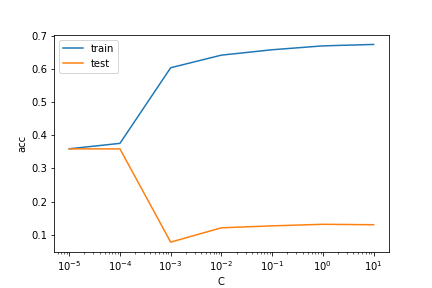

In [200]:
acc_train, acc_val = [], []
# C_toUse = np.array([1000,100,10,1,0.1,0.01,0.001,0.0001,0.00001])
C_toUse = np.array([10,1,0.1,0.01,0.001,0.0001,0.00001])
# C_toUse = np.array([1e9, 1e6])
for C in C_toUse:
#     print(f'C = {C}')
    logreg = sklearn.linear_model.LogisticRegression(solver='liblinear', max_iter=2000, C=C)
#     tic = time.time()
    logreg.fit(features_embedded_tr, y_labeled_train_SYT)
#     logreg.fit(features_train, y_labeled_train_SYT)
#     print(f'time: {time.time() - tic}')
    acc = logreg.score(features_embedded_tr, y_labeled_train_SYT)
#     acc = logreg.score(features_train, y_labeled_train_SYT)
    acc_train.append(acc)
#     print(f'acc_train: {acc}')
    acc = logreg.score(features_embedded_val, y_labeled_val_SYT)
#     acc = logreg.score(features_val, y_labeled_val_SYT)
    acc_val.append(acc)
#     print(f'acc_val: {acc}')
#     print('')
    

plt.figure()
plt.plot(C_toUse, acc_train)
plt.plot(C_toUse, acc_val)
plt.xscale('log')
plt.xlabel('C')
plt.ylabel('acc')
plt.legend(['train', 'test']);

In [ ]:
# acc_train, acc_val = [], []
# # C_toUse = np.array([1000,100,10,1,0.1,0.01,0.001,0.0001,0.00001])
# # C_toUse = np.array([10,1,0.1,0.01,0.001,0.0001,0.00001])
# C_toUse = np.array([10000])
# for C in tqdm(C_toUse):
# #     print(f'C = {C}')
#     logreg = sklearn.linear_model.LogisticRegression(solver='liblinear', max_iter=800, C=C)
# #     tic = time.time()
#     logreg.fit(features_train, y_labeled_train_SYT)
# #     print(f'time: {time.time() - tic}')
#     acc = logreg.score(features_train, y_labeled_train_SYT)
#     acc_train.append(acc)
# #     print(f'acc_train: {acc}')
#     acc = logreg.score(features_val, y_labeled_val_SYT)
#     acc_val.append(acc)
# #     print(f'acc_val: {acc}')
# #     print('')
    

# plt.figure()
# plt.plot(C_toUse, acc_train)
# plt.plot(C_toUse, acc_val)
# plt.xscale('log')
# plt.xlabel('C')
# plt.ylabel('acc')
# plt.legend(['train', 'test']);

run a sinlg logistic regression with desired parameters and check confusion matrix

In [ ]:
features_train.shape

In [ ]:
y_labeled_train_SYT.shape

In [ ]:
%matplotlib notebook
plt.figure()
plt.imshow(features_train[:100], aspect='auto')

In [ ]:
from sklearn.model_selection import ShuffleSplit
splitter = ShuffleSplit(n_splits=50)
all_split_inx = list(splitter.split(features_train))

train_X = [features_train[_[0]] for _ in all_split_inx]
# train_y = [y_labeled_train[_[0]] for _ in all_split_inx]
train_y = [y_labeled_train_SYT[_[0]] for _ in all_split_inx]
test_X = [features_train[_[1]] for _ in all_split_inx]
# test_y = [y_labeled_train[_[1]] for _ in all_split_inx]
test_y = [y_labeled_train_SYT[_[1]] for _ in all_split_inx]

%matplotlib inline

c_lst = [1e1, 1e0, 1e-1, 1e-2, 1e-3]

fig, ax = plt.subplots(len(c_lst), 2, figsize=(10,10))
plt.suptitle(f'{model_file_name}')

for ic, c in enumerate(c_lst):
    train_cms = []
    test_cms = []
    for inx_split in trange(len(train_X)):
        tmp_train_X = train_X[inx_split]
        tmp_train_y = train_y[inx_split]
        
        tmp_test_X = test_X[inx_split]
        tmp_test_y = test_y[inx_split]
        
        logreg = sklearn.linear_model.LogisticRegression(solver='liblinear', max_iter=800, C=c).fit(tmp_train_X, tmp_train_y)
        
        
        
        
        
        proba = logreg.predict_proba(tmp_train_X)

        preds = np.argmax(proba, axis=1)
        cm = classification.confusion_matrix(preds, tmp_train_y)
        train_cms.append(cm)

#         plt.figure()
#         sns.heatmap(cm, annot=True, annot_kws={"size": 16}, vmax=1., cmap=plt.get_cmap('gray'))
#         plt.title('train');
        
        proba = logreg.predict_proba(tmp_test_X)
        preds = np.argmax(proba, axis=1)
        cm = classification.confusion_matrix(preds, tmp_test_y)
        test_cms.append(cm)
        
#         plt.figure()
#         sns.heatmap(cm, annot=True, annot_kws={"size": 16}, vmax=1., cmap=plt.get_cmap('gray'))
#         plt.title('val');

    sns.heatmap(np.mean(train_cms,axis=0), annot=True, annot_kws={"size": 16}, vmax=1., cmap=plt.get_cmap('gray'), ax=ax[ic, 0])
    ax[ic, 0].set_title(f'train — C:{c}');

    sns.heatmap(np.mean(test_cms,axis=0), annot=True, annot_kws={"size": 16}, vmax=1., cmap=plt.get_cmap('gray'), ax=ax[ic, 1])
    ax[ic, 1].set_title(f'val — C:{c}');

plt.tight_layout()


In [153]:
logreg = sklearn.linear_model.LogisticRegression(solver='liblinear', max_iter=800, C=10**(0)).fit(features_train, y_labeled_train_SYT)

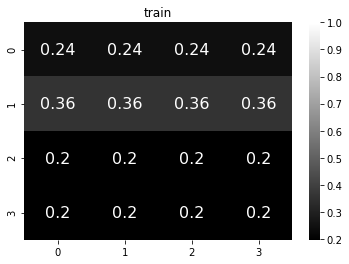

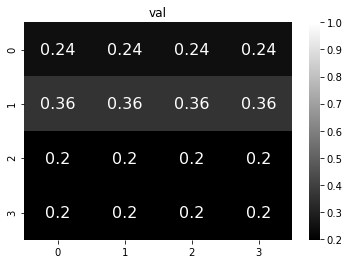

In [156]:
%matplotlib inline
proba = logreg.predict_proba(features_train)

preds = np.argmax(proba, axis=1)
cm = classification.confusion_matrix(proba, y_labeled_train_SYT)

plt.figure()
sns.heatmap(cm, annot=True, annot_kws={"size": 16}, vmax=1., cmap=plt.get_cmap('gray'))
plt.title('train');

proba = logreg.predict_proba(features_val)
preds = np.argmax(proba, axis=1)
cm = classification.confusion_matrix(proba, y_labeled_val_SYT)

plt.figure()
sns.heatmap(cm, annot=True, annot_kws={"size": 16}, vmax=1., cmap=plt.get_cmap('gray'))
plt.title('val');


<IPython.core.display.Javascript object>


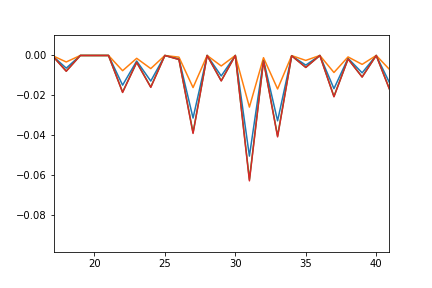

In [167]:
%matplotlib notebook
plt.figure()
plt.plot(logreg.coef_.T)

array([0.24447938, 0.        , 0.        , 0.35922419, 0.        ,
       0.        , 0.19936385, 0.        , 0.        , 0.19693258])

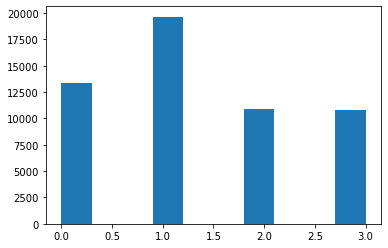

In [164]:
plt.figure()
out = plt.hist(y_labeled_train_SYT, )
out[0]/out[0].sum()

In [ ]:
# %matplotlib notebook
# proba = logreg.predict_proba(features_train)

# preds = np.argmax(proba, axis=1)
# cm = classification.confusion_matrix(preds, y_labeled_train_SYT)

# plt.figure()
# sns.heatmap(cm, annot=True, annot_kws={"size": 16}, vmax=1., cmap=plt.get_cmap('gray'))
# plt.title('train');

# proba = logreg.predict_proba(features_val)
# preds = np.argmax(proba, axis=1)
# cm = classification.confusion_matrix(preds, y_labeled_val_SYT)

# plt.figure()
# sns.heatmap(cm, annot=True, annot_kws={"size": 16}, vmax=1., cmap=plt.get_cmap('gray'))
# plt.title('val');


## Check embeddings

In [ ]:
model.eval();
# model.to(DEVICE);

In [ ]:
torch.cuda.empty_cache()

In [ ]:
dataset_unlabeled_noAug = util.dataset_simCLR(
                                    torch.as_tensor(masks_cat[:], device='cpu', dtype=torch.float32), 
                                    torch.as_tensor(torch.zeros(masks_cat[:].shape[0]), device='cpu', dtype=torch.float32),

                                    n_transforms=1,
                                    class_weights=np.array([1]),
                                    # class_weights=np.array([1]*4)[np.random.randint(0,4, X_train.shape[0])],
                                    transform=scripted_transforms_validation,
                                    # DEVICE='cpu',
                                    DEVICE='cpu',
                                    dtype_X=torch.float32,
                                    dtype_y=torch.int64,
                                    
                                    temp_uncertainty=16
                                    )
dataloader_unlabeled_noAug = torch.utils.data.DataLoader( dataset_unlabeled_noAug,
#                                                 batch_size=int(pct_batch_size*X_train.shape[0]),
                                                batch_size=1024,
                                                shuffle=False,
                                                drop_last=False,
                                                pin_memory=True,
                                                num_workers=32,
                                                persistent_workers=True,
                                                # prefetch_factor=0
                                                )

In [ ]:
dataset_unlabeled_noAug = util.dataset_simCLR(
                                    torch.as_tensor(masks_SYT[:], device='cpu', dtype=torch.float32), 
                                    torch.as_tensor(torch.zeros(masks_SYT[:].shape[0]), device='cpu', dtype=torch.float32),

                                    n_transforms=1,
                                    class_weights=np.array([1]),
                                    # class_weights=np.array([1]*4)[np.random.randint(0,4, X_train.shape[0])],
                                    transform=scripted_transforms_validation,
                                    # DEVICE='cpu',
                                    DEVICE='cpu',
                                    dtype_X=torch.float32,
                                    dtype_y=torch.int64,
                                    
                                    temp_uncertainty=16
                                    )
dataloader_unlabeled_noAug = torch.utils.data.DataLoader( dataset_unlabeled_noAug,
#                                                 batch_size=int(pct_batch_size*X_train.shape[0]),
                                                batch_size=1024,
                                                shuffle=False,
                                                drop_last=False,
                                                pin_memory=True,
                                                num_workers=32,
                                                persistent_workers=True,
                                                # prefetch_factor=0
                                                )

In [ ]:
# optional: run unlabeled data through model
features_train = torch.cat([model.get_head(model.base_model(data[0][0].to(DEVICE))).detach().cpu() for data in dataloader_unlabeled_noAug], dim=0)

In [137]:
### REMOVE

# DEVICE='cuda'
DEVICE='cpu'

In [138]:
# model.to(DEVICE);

In [143]:
_, features_embedded, _, evr = decomposition.torch_pca(features_train, device=DEVICE, return_cpu=True)

In [ ]:
tsne = cuml.TSNE( n_components=2,
                  perplexity=50.0,
                  early_exaggeration=12.0,
#                   late_exaggeration=1.0,
                  learning_rate=200.0,
                  n_iter=1000,
                  n_iter_without_progress=300,
                  min_grad_norm=1e-07,
                  metric='euclidean',
                  init='random',
                  verbose=False,
#                   random_state=None,
#                   method='barnes_hut',
#                   angle=0.5,
#                   learning_rate_method='adaptive',
# #                   n_neighbors=90,
#                   perplexity_max_iter=100,
#                   exaggeration_iter=250,
#                   pre_momentum=0.5,
#                   post_momentum=0.8,
# #                   square_distances=True,
#                   handle=None,
#                   output_type=None
                )
features_embedded = tsne.fit_transform(features_train.to(DEVICE)).get()

In [ ]:
umap = cuml.UMAP(n_neighbors=100,
                n_components=2,
                n_epochs=None,
                learning_rate=1.0,
                min_dist=0.1,
                spread=1.0,
                set_op_mix_ratio=1.0, 
                local_connectivity=1.0,
                repulsion_strength=1.0, 
                negative_sample_rate=5, 
                transform_queue_size=4.0, 
                init='spectral', 
                verbose=False,
                a=None, 
                b=None, 
                target_n_neighbors=- 1, 
#                 target_weight=0.5, 
                target_metric='categorical', 
                handle=None,                
                hash_input=False, 
                random_state=None, 
                callback=None, 
                output_type=None
                )
features_embedded = umap.fit_transform(features_train.to(DEVICE)).get()

In [ ]:
from sklearn import manifold

tsne = manifold.TSNE(n_components=2, 
                     perplexity=120.0, 
                     early_exaggeration=12.0, 
                     learning_rate=200, 
                     n_iter=1000, 
                     n_iter_without_progress=300, 
                     min_grad_norm=1e-07, 
                     metric='euclidean', 
                     init='pca', 
                     verbose=0, 
                     random_state=None, 
                     method='barnes_hut', 
                     angle=0.5, 
                     n_jobs=-1, 
#                      square_distances='legacy'
                    )
features_embedded = tsne.fit_transform(features_train.cpu())
# features_embedded = tsne.fit_transform(features_embedded[:,:5].cpu())

<IPython.core.display.Javascript object>


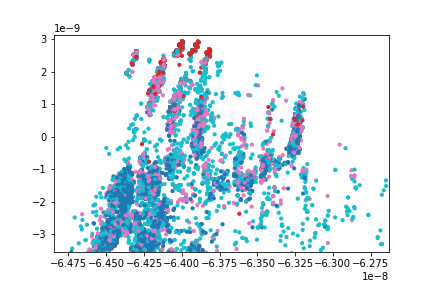

In [168]:
import matplotlib as mpl

# mpl.rcParams['image.cmap'] = 'Set1'
%matplotlib notebook
plt.figure()
plt.scatter(features_embedded[:,0], features_embedded[:,1], s=10, c=y_labeled_train_SYT, cmap=plt.get_cmap('tab10'))
# plt.scatter(features_embedded[:,0], features_embedded[:,1], s=10, c=y_labeled_train_SYT, cmap=plt.get_cmap('viridis'))
# plt.scatter(features_embedded[:,0], features_embedded[:,1], s=0.001)
# plt.scatter(features_embedded[:,0], features_embedded[:,1], c=labels[labels!=3])
# plt.scatter(features_embedded[:,0], features_embedded[:,1], c=y_val)
# plt.scatter(features_embedded[:,4], features_embedded[:,5], c=y_train)
# plt.scatter(features_embedded[:,11], features[:,43].cpu(), c=y_train)


In [ ]:
import matplotlib as mpl

# mpl.rcParams['image.cmap'] = 'Set1'
%matplotlib notebook
plt.figure()
# plt.scatter(features_embedded[:,0], features_embedded[:,1], s=30, c=y_labeled_train, cmap=plt.get_cmap('tab10'))
plt.scatter(features_embedded[:,0], features_embedded[:,1], s=0.2)
# plt.scatter(features_embedded[:,0], features_embedded[:,1], c=labels[labels!=3])
# plt.scatter(features_embedded[:,0], features_embedded[:,1], c=y_val)
# plt.scatter(features_embedded[:,4], features_embedded[:,5], c=y_train)
# plt.scatter(features_embedded[:,11], features[:,43].cpu(), c=y_train)


In [ ]:
plt.figure()
plt.imshow(features_train.cpu().detach(), aspect='auto', interpolation='antialiased')

In [ ]:
plt.figure()
plt.plot(evr)
# plt.yscale('log')

In [ ]:
plt.figure()
plt.plot(evr)
# plt.yscale('log')

In [ ]:
plt.figure()
plt.plot(evr)
# plt.yscale('log')

In [ ]:
plt.figure()
plt.plot(evr)
# plt.yscale('log')

## Check filters

In [202]:
list(model.state_dict().keys())

['base_model.0.0.0.weight',
 'base_model.0.0.1.weight',
 'base_model.0.0.1.bias',
 'base_model.0.0.1.running_mean',
 'base_model.0.0.1.running_var',
 'base_model.0.0.1.num_batches_tracked',
 'base_model.0.1.block.0.0.weight',
 'base_model.0.1.block.0.1.weight',
 'base_model.0.1.block.0.1.bias',
 'base_model.0.1.block.0.1.running_mean',
 'base_model.0.1.block.0.1.running_var',
 'base_model.0.1.block.0.1.num_batches_tracked',
 'base_model.0.1.block.1.fc1.weight',
 'base_model.0.1.block.1.fc1.bias',
 'base_model.0.1.block.1.fc2.weight',
 'base_model.0.1.block.1.fc2.bias',
 'base_model.0.1.block.2.0.weight',
 'base_model.0.1.block.2.1.weight',
 'base_model.0.1.block.2.1.bias',
 'base_model.0.1.block.2.1.running_mean',
 'base_model.0.1.block.2.1.running_var',
 'base_model.0.1.block.2.1.num_batches_tracked',
 'base_model.0.2.block.0.0.weight',
 'base_model.0.2.block.0.1.weight',
 'base_model.0.2.block.0.1.bias',
 'base_model.0.2.block.0.1.running_mean',
 'base_model.0.2.block.0.1.running_var

<IPython.core.display.Javascript object>


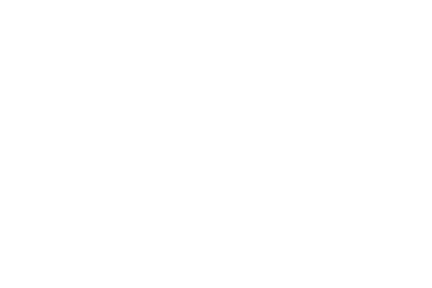

In [215]:
layer_1 = model.state_dict()['base_model.0.0.0.weight'].cpu()
layer_2 = model.state_dict()['base_model.0.1.block.0.0.weight'].cpu()
# layer_3 = model.state_dict()['base_model.7.0.conv1.weight'].cpu()
# layer_4 = model.state_dict()['base_model.7.1.conv2.weight'].cpu()

plt.figure()
# for ii in range(layer_1.shape[1]):
#     for jj in range(layer_1.shape[0]): 
for ii in range(1):
    for jj in range(16):        
        plt.subplot2grid((1,16),(ii,jj))
#         plt.subplot2grid((layer_1.shape[1],layer_1.shape[0]),(ii,jj))        
        fig = plt.imshow(layer_1[jj,ii,:,:] , clim=(-0.2,0.2))
        fig.axes.get_xaxis().set_visible(False)
        fig.axes.get_yaxis().set_visible(False)

plt.figure()
for ii in range(16):
    for jj in range(16):
        plt.subplot2grid((16,16),(ii,jj))
        fig = plt.imshow(layer_2[jj,ii,:,:], clim=(-.05,.05))
        fig.axes.get_xaxis().set_visible(False)
        fig.axes.get_yaxis().set_visible(False)

plt.figure()
for ii in range(16):
    for jj in range(16):
        plt.subplot2grid((16,16),(ii,jj))
        fig = plt.imshow(layer_3[jj, ii,:,:], clim=(-.1,.1))
        fig.axes.get_xaxis().set_visible(False)
        fig.axes.get_yaxis().set_visible(False)
        
plt.figure()
for ii in range(16):
    for jj in range(16):
        plt.subplot2grid((16,16),(ii,jj))
        fig = plt.imshow(layer_4[jj, ii,:,:], clim=(-.1,.1))
        fig.axes.get_xaxis().set_visible(False)
        fig.axes.get_yaxis().set_visible(False)

In [ ]:
# torch.save(model.state_dict(), '/media/rich/bigSSD/Net_trainedOnAug_20211025_trainingSet_mouse628_20200903and20200815_simCLR.pth')

In [ ]:
# model = Net()
# model.load_state_dict(torch.load('test_save.pth'))
# model.eval()

# Graveyard

In [ ]:
data_unlabeled = torch.as_tensor(masks_cat, dtype=torch.float32, device='cpu')

model.to(DEVICE)

# penalized_params = list(model.modules())[-1].parameters()
# penalized_params = torch.cat([_.view(-1) for _ in penalized_params], -1)

early_stopping = 50
prv_best_val = np.inf
early_stopping_cnt = 0

l2_alpha = 0.1

n_epochs=300000
for epoch in range(n_epochs):
    print(f'epoch: {epoch}')
#     loss_rolling_train, loss_rolling_val = training_supervised.epoch_step(dataloader_train, 
#                                     model, 
#                                     optimizer, 
#                                     criterion, 

#                                     penalized_params, l2_alpha,

#                                     scheduler=scheduler,
#                                     loss_rolling_train=losses_train, 
#                                     device=DEVICE, 
#                                     loss_rolling_val=losses_val,
#                                     verbose=2,
#                                     verbose_update_period=100,
                                   
#                                     do_validation=True,
#                                     X_val=x_feed_through_val,
#                                     y_val=torch.as_tensor(y_val, device=DEVICE)
#                                    )
    
    loss_rolling_train, loss_rolling_val = training_simCLR.epoch_step(dataloader_train, 
                                    model, 
                                    optimizer, 
                                    criterion, 

                                    # penalized_params, l2_alpha,

                                    scheduler=scheduler,
                                    loss_rolling_train=losses_train, 
                                    device=DEVICE, 
                                    loss_rolling_val=losses_val,
                                    verbose=2,
                                    verbose_update_period=100,
                                   
                                    do_validation=True,
                                    X_val=x_feed_through_val,
                                    y_val=torch.as_tensor(y_val, device=DEVICE)
                                   )
    
    
    if early_stopping:
      if len(loss_rolling_val) > 0:
        if loss_rolling_val[-1] < prv_best_val:
          early_stopping_cnt = 0
          prv_best_val = loss_rolling_val[-1]
          torch.save(model.state_dict(), f'{base_dir}/github_repos/GCaMP_ROI_classifier/new_stuff/models/checkpoints/checkpoint.pth')
        else:
          early_stopping_cnt += 1
    
      if early_stopping_cnt >= early_stopping:
        model.load_state_dict(torch.load(f'{base_dir}/github_repos/GCaMP_ROI_classifier/new_stuff/models/checkpoints/checkpoint.pth'))
        break
    
    # torch_helpers.show_all_tensors(globals())
    
    features_train = model(x_feed_through_tr)
    features_train = features_train.cpu().detach().numpy()
    features_val = model(x_feed_through_val)
    features_val = features_val.cpu().detach().numpy()
    # y_hat = scipy.special.softmax(features_val, axis=-1) # logreg.predict_proba(features_val)
    
    print('Training Confusion Matrix')
    print(get_cm(features_train, y_train))
    print()
    print(logistic_pred_train)

    print()
    print()

    print('Val Confusion Matrix')
    print(get_cm(features_val, y_val))
    print()
    print(logistic_pred_val)

    # model.to(DEVICE)
    print()
    print()
